# AE outlier detection on CIFAR10

### Method

The Auto-Encoder (AE) outlier detector is first trained on a batch of unlabeled, but normal (inlier) data. Unsupervised training is desireable since labeled data is often scarce. The AE detector tries to reconstruct the input it receives. If the input data cannot be reconstructed well, the reconstruction error is high and the data can be flagged as an outlier. The reconstruction error is  measured as the mean squared error (MSE) between the input and the reconstructed instance.

## Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes.

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, \
    Dense, Layer, Reshape, InputLayer, Flatten
from tqdm import tqdm

from alibi_detect.od import OutlierAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

2023-07-10 14:06:55.987507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 14:06:56.146470: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 14:06:56.789882: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/vishesh/anaconda3/lib/:/home/vishesh/anaconda3/lib/python3.9/site-packages/nvidi

In [2]:
tf.test.is_gpu_available()

2023-07-10 14:07:00.919634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 14:07:01.011659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 14:07:01.012257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 14:07:01.492609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 14:07:01.493418: I tensorflow/compiler/xla/stream_executo

True

## Load CIFAR10 data

In [423]:
train_data_dir = "/home/vishesh/Desktop/datasets/ships-data/X_true_train_240_320"
train_ground_truth_dir = "/home/vishesh/Desktop/datasets/ships-data/Y_true_train_240_320"

test_data_path = "/home/vishesh/Desktop/datasets/ships-data/X_true_val_240_320/1.npy"
test_ground_truth_path = "/home/vishesh/Desktop/datasets/ships-data/Y_true_val_240_320/1.npy"

perturbation = "shot_noise"
strength = 10
perturbed_dataset_path = f"/home/vishesh/Desktop/datasets/ships-data/perturbed_test/varying/{perturbation}/{strength}/1.npy"

In [424]:
# X_train = None
# y_train = None


# for i in range(1,11):
#     print(i)
#     input_data_path = os.path.join(train_data_dir, f"{i}.npy")
#     ground_truth_path = os.path.join(train_ground_truth_dir, f"{i}.npy")
    
#     if i == 1:
#         X_train = np.load(input_data_path)
#         y_train = np.load(ground_truth_path)
#         continue
        
        
#     new_input_data = np.load(input_data_path)
#     new_ground_truth = np.load(ground_truth_path)
    

#     X_train = np.vstack((X_train, new_input_data))
#     y_train = np.hstack((y_train, new_ground_truth))
    
# y_train = y_train.astype(int)

In [425]:
X_test = np.load(test_data_path)
y_test = np.load(test_ground_truth_path).astype(int)

perturbed_dataset = np.load(perturbed_dataset_path)
X_test[-200:] = perturbed_dataset[-200:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 240, 320, 3) (10000,) (1000, 240, 320, 3) (1000,)


## Load or define outlier detector

The pretrained outlier and adversarial detectors used in the example notebooks can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can use the built-in ```fetch_detector``` function which saves the pre-trained models in a local directory ```filepath``` and loads the detector. Alternatively, you can train a detector from scratch:

In [426]:
model = tf.keras.models.load_model("my_model.h5", compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')

In [427]:
od = OutlierAE(ae=model, threshold=.015)

## Check quality AE model

In [428]:
idx = 983
X = X_test[idx].reshape(1, 240, 320, 3)
X_recon = od.ae(X)

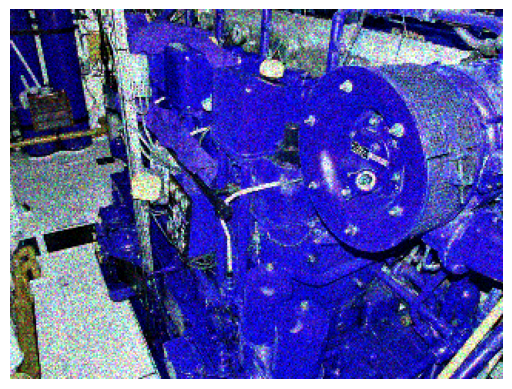

In [429]:
plt.imshow(X.reshape(240, 320, 3))
plt.axis('off')
plt.show()

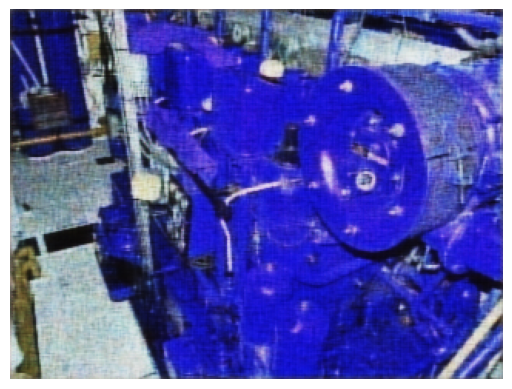

In [430]:
plt.imshow(X_recon.numpy().reshape(240, 320, 3))
plt.axis('off')
plt.show()

## Check outliers on original CIFAR images

In [431]:
X = X_test
print(X.shape)

(1000, 240, 320, 3)


In [432]:
od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True,
                      batch_size=256)
print(list(od_preds['data'].keys()))

['instance_score', 'feature_score', 'is_outlier']


### Plot instance level outlier scores

In [433]:
thresh = np.percentile(od_preds['data']["instance_score"][:800], 90)

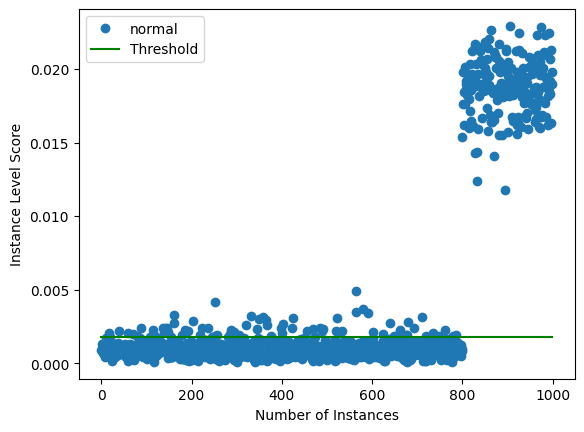

In [434]:
target = np.zeros(X.shape[0],).astype(int)  # all normal CIFAR10 training instances
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, thresh)

In [435]:
od_preds['data']["instance_score"][800:][od_preds['data']["instance_score"][800:] > thresh].shape[0] / 200 # True positives

1.0

In [436]:
od_preds['data']["instance_score"][:800][od_preds['data']["instance_score"][:800] > thresh].shape[0] / 800 # False positives

0.1

In [437]:
np.argmax(od_preds['data']["instance_score"][800:])

106

### Visualize predictions

In [ ]:
X_recon = od.ae(X).numpy()
plot_feature_outlier_image(od_preds, 
                           X, 
                           X_recon=X_recon,
                           instance_ids=[8, 60, 100, 330],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions

## Predict outliers on perturbed CIFAR images

We perturb CIFAR images by adding random noise to patches (masks) of the image. For each mask size in `n_mask_sizes`, sample `n_masks` and apply those to each of the `n_imgs` images. Then we predict outliers on the masked instances: 

In [ ]:
# nb of predictions per image: n_masks * n_mask_sizes 
n_mask_sizes = 10
n_masks = 20
n_imgs = 50

Define masks and get images:

In [ ]:
mask_sizes = [(2*n,2*n) for n in range(1,n_mask_sizes+1)]
print(mask_sizes)
img_ids = np.arange(n_imgs)
X_orig = X[img_ids].reshape(img_ids.shape[0], 32, 32, 3)
print(X_orig.shape)

Calculate instance level outlier scores:

In [ ]:
all_img_scores = []
for i in tqdm(range(X_orig.shape[0])):
    img_scores = np.zeros((len(mask_sizes),))
    for j, mask_size in enumerate(mask_sizes):
        # create masked instances
        X_mask, mask = apply_mask(X_orig[i].reshape(1, 32, 32, 3),
                                  mask_size=mask_size,
                                  n_masks=n_masks,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))
        # predict outliers
        od_preds_mask = od.predict(X_mask)
        score = od_preds_mask['data']['instance_score']
        # store average score over `n_masks` for a given mask size
        img_scores[j] = np.mean(score)
    all_img_scores.append(img_scores)

### Visualize outlier scores vs. mask sizes

In [ ]:
x_plt = [mask[0] for mask in mask_sizes]

In [ ]:
for ais in all_img_scores:
    plt.plot(x_plt, ais)
    plt.xticks(x_plt)
plt.title('Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask size')
plt.ylabel('Outlier Score')
plt.show()

In [ ]:
ais_np = np.zeros((len(all_img_scores), all_img_scores[0].shape[0]))
for i, ais in enumerate(all_img_scores):
    ais_np[i, :] = ais
ais_mean = np.mean(ais_np, axis=0)
plt.title('Mean Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask size')
plt.ylabel('Outlier score')
plt.plot(x_plt, ais_mean)
plt.xticks(x_plt)
plt.show()

### Investigate instance level outlier

In [ ]:
i = 8  # index of instance to look at

In [ ]:
plt.plot(x_plt, all_img_scores[i])
plt.xticks(x_plt)
plt.title('Outlier Scores Image {} for Increasing Mask Size'.format(i))
plt.xlabel('Mask size')
plt.ylabel('Outlier score')
plt.show()

Reconstruction of masked images and outlier scores per channel:

In [ ]:
all_X_mask = []
X_i = X_orig[i].reshape(1, 32, 32, 3)
all_X_mask.append(X_i)
# apply masks
for j, mask_size in enumerate(mask_sizes):
    # create masked instances
    X_mask, mask = apply_mask(X_i,
                              mask_size=mask_size,
                              n_masks=1,  # just 1 for visualization purposes
                              channels=[0,1,2],
                              mask_type='normal',
                              noise_distr=(0,1),
                              clip_rng=(0,1))
    all_X_mask.append(X_mask)
all_X_mask = np.concatenate(all_X_mask, axis=0)
all_X_recon = od.ae(all_X_mask).numpy()
od_preds = od.predict(all_X_mask)

Visualize:

In [ ]:
plot_feature_outlier_image(od_preds, 
                           all_X_mask, 
                           X_recon=all_X_recon, 
                           max_instances=all_X_mask.shape[0], 
                           n_channels=3)

## Predict outliers on a subset of features

The sensitivity of the outlier detector can not only be controlled via the `threshold`, but also by selecting the percentage of the features used for the instance level outlier score computation. For instance, we might want to flag outliers if 40% of the features (pixels for images) have an average outlier score above the threshold. This is possible via the `outlier_perc` argument in the `predict` function. It specifies the percentage of the features that are used for outlier detection, sorted in descending outlier score order. 

In [ ]:
perc_list = [20, 40, 60, 80, 100]

all_perc_scores = []
for perc in perc_list:
    od_preds_perc = od.predict(all_X_mask, outlier_perc=perc)
    iscore = od_preds_perc['data']['instance_score']
    all_perc_scores.append(iscore)

Visualize outlier scores vs. mask sizes and percentage of features used:

In [ ]:
x_plt = [0] + x_plt
for aps in all_perc_scores:
    plt.plot(x_plt, aps)
    plt.xticks(x_plt)
plt.legend(perc_list)
plt.title('Outlier Score for Increasing Mask Size and Different Feature Subsets')
plt.xlabel('Mask Size')
plt.ylabel('Outlier Score')
plt.show()

## Infer outlier threshold value

Finding good threshold values can be tricky since they are typically not easy to interpret. The `infer_threshold` method helps finding a sensible value. We need to pass a batch of instances `X` and specify what percentage of those we consider to be normal via `threshold_perc`.

In [ ]:
print('Current threshold: {}'.format(od.threshold))
od.infer_threshold(X, threshold_perc=99)  # assume 1% of the training data are outliers
print('New threshold: {}'.format(od.threshold))